#### Libraries

In [ ]:
import sys
sys.path.append("../common")

from clean_data import (
    contains_emoji,
    filter_non_standard_words,
    get_stop_words,
    generate_grams,
    remove_emoji
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
stop_words = get_stop_words()
jigsaw_df = pd.read_csv("../data/raw/train.csv")

jigsaw_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
jigsaw_df['comment_text'].where(jigsaw_df['comment_text'].apply(contains_emoji)).count()

np.int64(1198)

In [4]:
jigsaw_cleaned_df = jigsaw_df.copy()
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].apply(remove_emoji)
jigsaw_cleaned_df['comment_text'].where(jigsaw_cleaned_df['comment_text'].apply(contains_emoji)).count()

np.int64(0)

In [5]:
# Replace special characters with an empty string
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

# Convert multilabel dataset to binary label and drop the multilabel columns
jigsaw_cleaned_df['is_toxic'] = jigsaw_cleaned_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].any(axis=1).astype(int)
jigsaw_cleaned_df.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], inplace=True)
jigsaw_cleaned_df.head(5)

,id,comment_text,is_toxic
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0
3,0001b41b1c6bb37e,MoreI cant make any real suggestions on improv...,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0


### Visualizations

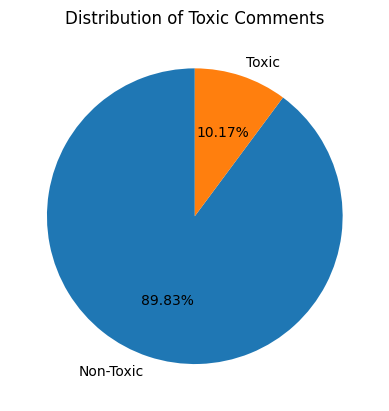

In [6]:
plt.pie(jigsaw_cleaned_df['is_toxic'].value_counts(), labels=['Non-Toxic', 'Toxic'], autopct='%1.2f%%', startangle=90)
plt.title('Distribution of Toxic Comments')
plt.show()

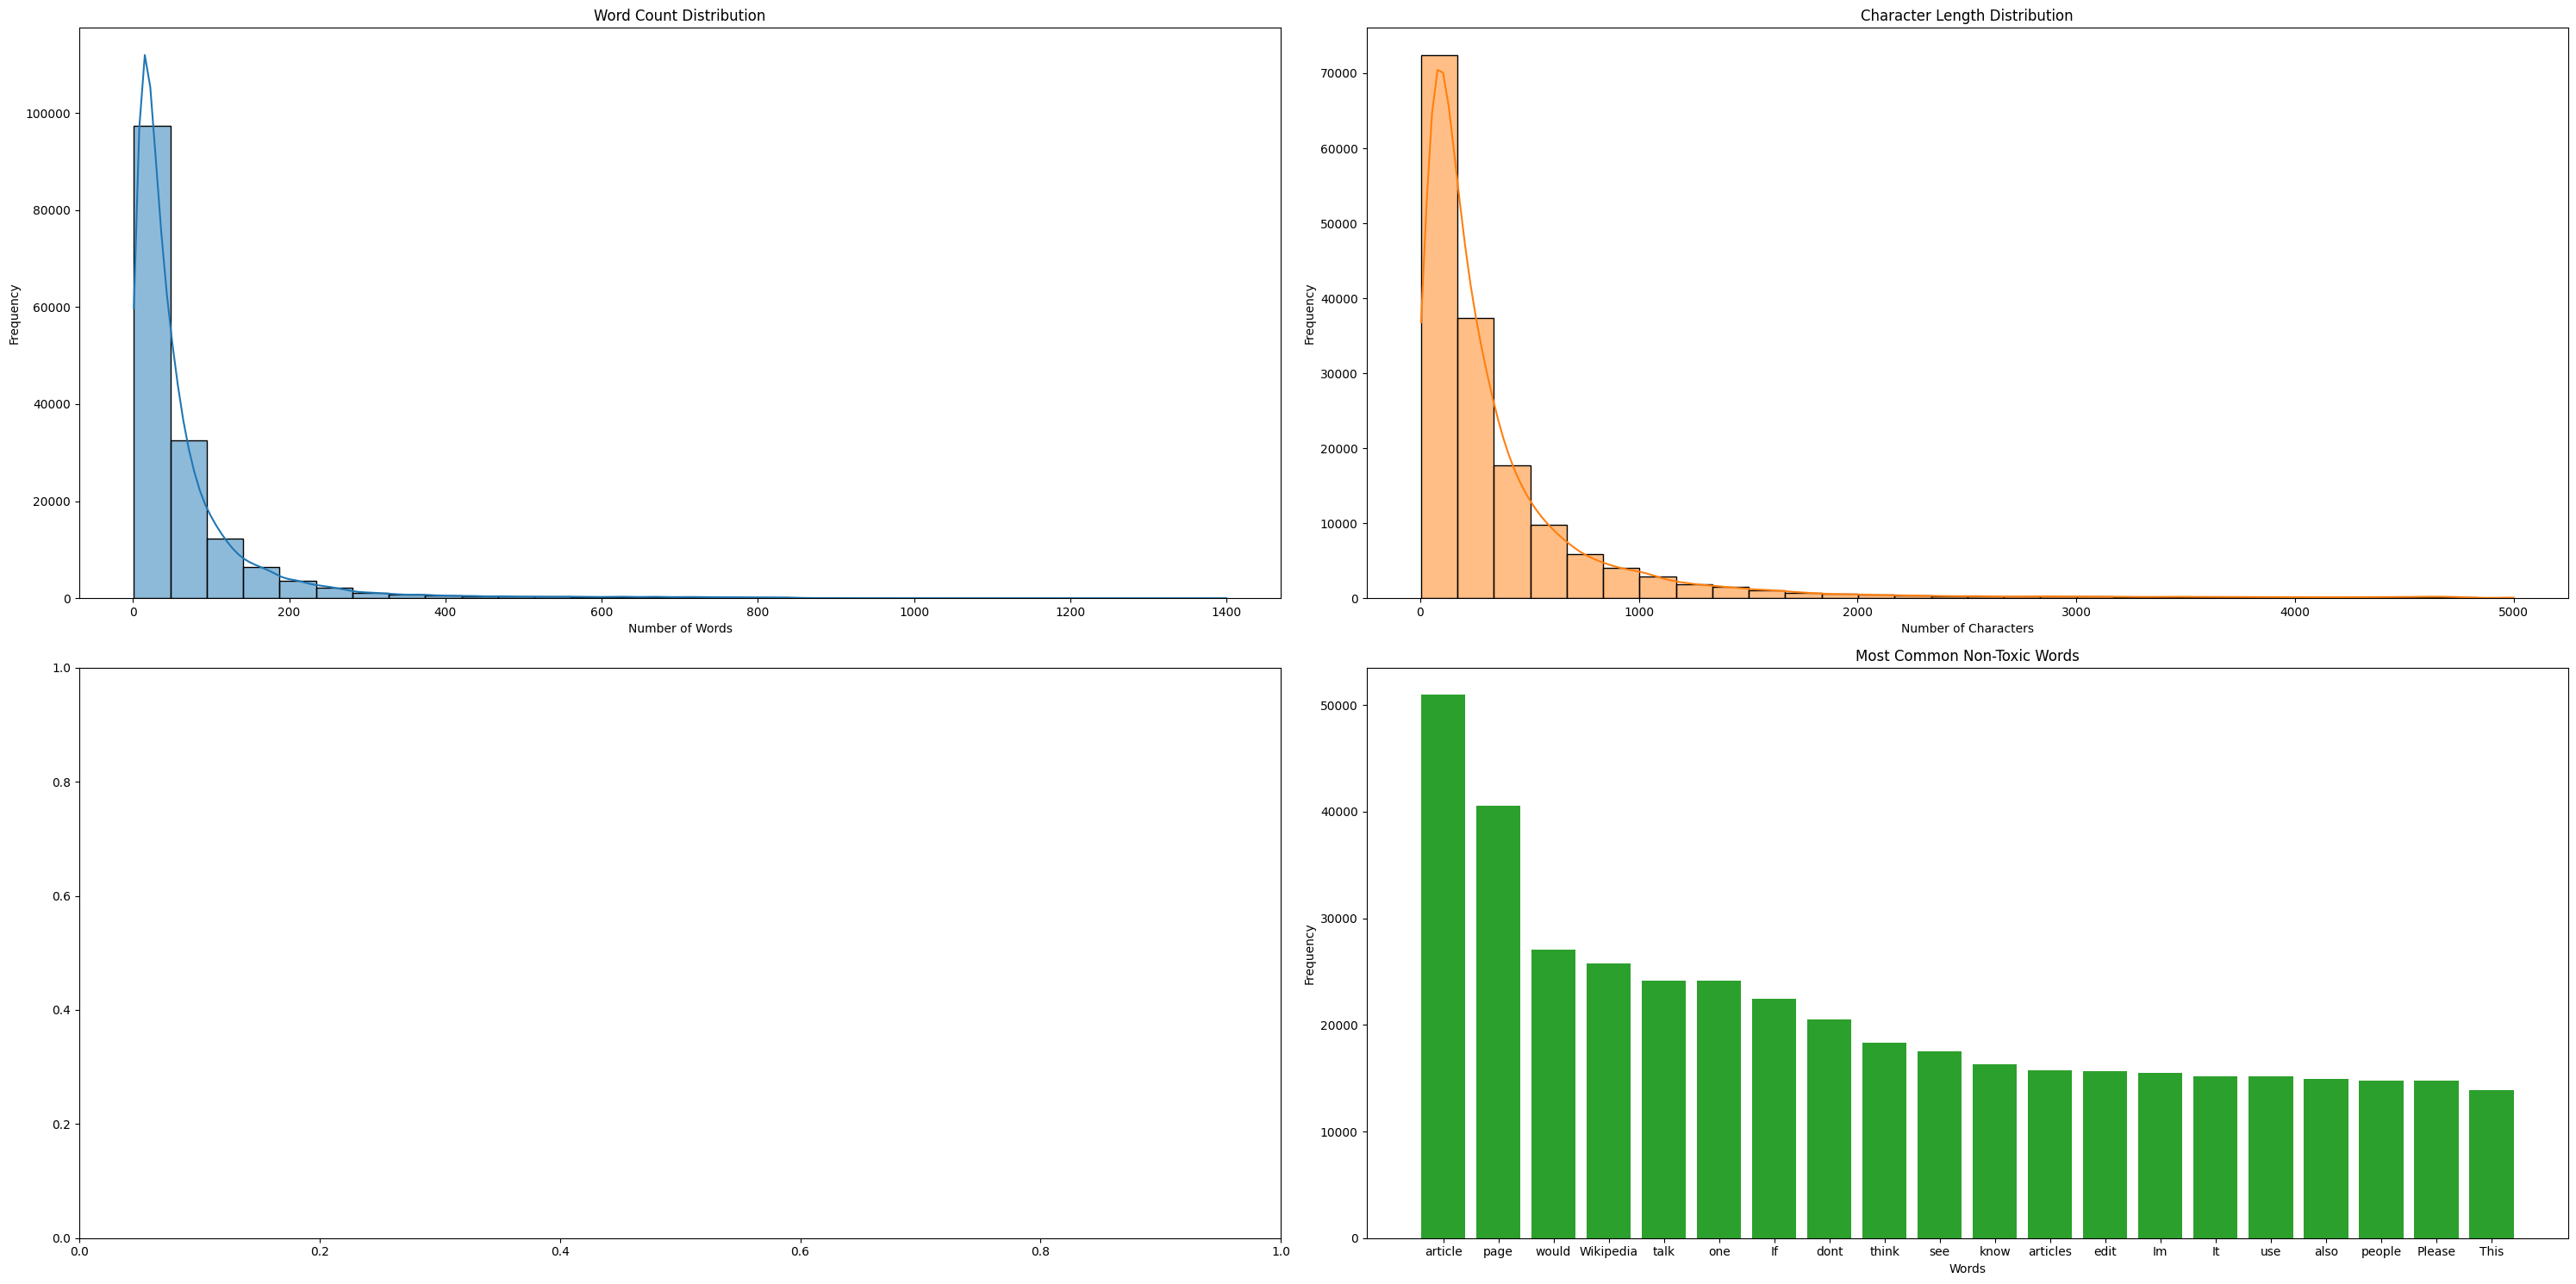

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(30, 15))

# ============= Word count distribution ============

# Split each and get length of each string in the comment_text column
sns.histplot(jigsaw_cleaned_df['comment_text'].str.split().str.len(), bins=30, kde=True, color='tab:blue', ax=axes[0,0])
axes[0,0].set_title('Word Count Distribution')
axes[0,0].set_xlabel('Number of Words')
axes[0,0].set_ylabel('Frequency')

# ============= Word count distribution ============


# ========== Character length distribution ==========

# Get length of each string in the comment_text column
sns.histplot(jigsaw_cleaned_df['comment_text'].str.len(), bins=30, kde=True, color='tab:orange', ax=axes[0,1])
axes[0,1].set_title('Character Length Distribution')
axes[0,1].set_xlabel('Number of Characters')
axes[0,1].set_ylabel('Frequency')

# ========== Character length distribution ==========


# ================= Toxic Words ====================

# Get toxic/non-toxic words, split and create dataframe out of split, flatten into series, and count
toxic_words = jigsaw_cleaned_df[jigsaw_cleaned_df['is_toxic'] == 1]['comment_text'] \
    .str.split(expand=True) \
    .stack() \
    .value_counts()

non_toxic_words = jigsaw_cleaned_df[jigsaw_cleaned_df['is_toxic'] == 0]['comment_text'] \
    .str.split(expand=True) \
    .stack() \
    .value_counts()


# Filter out stop words
toxic_words = toxic_words[~toxic_words.index.isin(stop_words)]
non_toxic_words = non_toxic_words[~non_toxic_words.index.isin(stop_words)]
top_n_words = 20


# Plot top n Toxic Words
# axes[1,0].bar(toxic_words.head(top_n_words).index, toxic_words.head(top_n_words).values, color='tab:red')
# axes[1,0].set_title('Most Common Toxic Words')
# axes[1,0].set_xlabel('Words')
# axes[1,0].set_ylabel('Frequency')


# Plot top n Non-Toxic Words
axes[1,1].bar(non_toxic_words.head(top_n_words).index, non_toxic_words.head(top_n_words).values, color='tab:green')
axes[1,1].set_title('Most Common Non-Toxic Words')
axes[1,1].set_xlabel('Words')
axes[1,1].set_ylabel('Frequency')

# ================= Toxic Words ====================


plt.tight_layout()
plt.show()

In [8]:
# N-gram analysis
for n in range(2, 5):
    # Generate n-grams and convert it to a Series of lists
    n_grams = jigsaw_cleaned_df['comment_text'].apply(lambda x: generate_grams(x, n))
    n_gram_df = pd.DataFrame(n_grams.tolist())

    # Group by n-grams
    n_gram_counts = n_gram_df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1).value_counts()
    print(n_gram_counts.head(10))